In [1]:
import os
from PIL import Image

input_folder = "images/xfx_512_512"
output_folder = "images/xfx_512_512_resized"

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        image = Image.open(input_path).convert("RGB")
        image = image.resize((512, 512), Image.LANCZOS)

        image.save(output_path)

        print(f"Resized: {filename}")

print("Done.")

Resized: xlgfx56_01.jpg
Resized: xlgfx30_06.jpg
Resized: xlgfx54_05 - Copy.jpg
Resized: xlgfx52_07.jpg
Resized: xlgfx42_07.jpg
Resized: xlgfx20_08.jpg
Resized: xlgfx23_06.jpg
Resized: xlgfx53_02.jpg
Resized: xlgfx23_10.jpg
Resized: xlgfx19_08.jpg
Resized: xlgfx31_08.jpg
Resized: xlgfx49_06.jpg
Resized: xlgfx52_06.jpg
Resized: xlgfx38_05.jpg
Resized: xlgfx42_05.jpg
Resized: xlgfx08_13.jpg
Resized: xlgfx56_06.jpg
Resized: xlgfx13_09.jpg
Resized: xlgfx45_05.jpg
Resized: xlgfx52_05.jpg
Resized: xlgfx51_08.jpg
Resized: xlgfx08_03.jpg
Resized: xlgfx08_01.jpg
Resized: xlgfx56_04.jpg
Resized: xlgfx43_03.jpg
Done.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import onnxruntime as ort
import pandas as pd
print("ONNX Runtime version:", ort.__version__)
ImagePath ='/home/aistudio/PytorchStableDiffusion/images/xfx_512_512'
WD14TaggerPath ='/home/aistudio/models/wd-v1-4-convnextv2-tagger-v2/model.onnx'
TagCSVPath = '/home/aistudio/models/wd-v1-4-convnextv2-tagger-v2/selected_tags.csv'
TriggerWords = 'xiaofeixiang'
session = ort.InferenceSession(WD14TaggerPath)
tags = pd.read_csv(TagCSVPath)
tagsList =tags['name'].tolist()
print(tagsList[:10])
fileList = os.listdir(ImagePath)
fileImageList = []
for fileName in fileList:
    if fileName.endswith('.jpg'):
        fileImageList.append(fileName)
fileList = fileImageList
print(fileList)
for fileName in fileList:    
    inputPath = os.path.join(ImagePath, fileName)
    print(inputPath)
    image = cv2.imread(inputPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)
    image = cv2.resize(image, (448, 448))
    #plt.imshow(image/255.0)
    #plt.show()
    #image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, axis=0)
    #print(image, image.shape)
    inputName = session.get_inputs()[0].name
    outPut = session.run(None,{inputName:image})
    print(type(outPut), len(outPut))
    print(outPut[0].shape)
    outPutIndexList =outPut[0][0]
    print(outPutIndexList)
    tagOutTextList = []
    for i,tagConfidene in enumerate(outPutIndexList):
        if tagConfidene > 0.2:
            tagOutTextList.append(tagsList[i].replace('_',' '))
    tagStr = TriggerWords
    for tag in tagOutTextList:
        tagStr = tagStr + ',' + tag       
    textPath = inputPath.split('.')[0] + '.txt'
    with open(textPath, 'w') as f:
        f.write(tagStr)
    print(tagStr)


ONNX Runtime version: 1.23.2
['general', 'sensitive', 'questionable', 'explicit', '1girl', 'solo', 'long_hair', 'breasts', 'looking_at_viewer', 'blush']
['xlgfx56_06.jpg', 'xlgfx56_04.jpg', 'xlgfx08_01.jpg', 'xlgfx08_13.jpg', 'xlgfx23_06.jpg', 'xlgfx08_03.jpg', 'xlgfx42_05.jpg', 'xlgfx49_06.jpg', 'xlgfx52_06.jpg', 'xlgfx54_05.jpg', 'xlgfx43_03.jpg', 'xlgfx31_08.jpg', 'xlgfx19_08.jpg', 'xlgfx51_08.jpg', 'xlgfx56_01.jpg', 'xlgfx13_09.jpg', 'xlgfx45_05.jpg', 'xlgfx53_02.jpg', 'xlgfx52_07.jpg', 'xlgfx52_05.jpg', 'xlgfx42_07.jpg', 'xlgfx38_05.jpg', 'xlgfx30_06.jpg', 'xlgfx23_10.jpg', 'xlgfx20_08.jpg']
/home/aistudio/PytorchStableDiffusion/images/xfx_512_512/xlgfx56_06.jpg
<class 'list'> 1
(1, 9083)
[6.2523067e-01 3.5084054e-01 3.4222007e-03 ... 1.0818243e-05 3.8146973e-06
 2.0563602e-06]
xiaofeixiang,general,sensitive,1girl,solo,long hair,looking at viewer,smile,bangs,shirt,black hair,animal ears,white shirt,upper body,outdoors,teeth,collared shirt,cat ears,grin,black eyes,colored skin,fang

In [29]:
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import CLIPTokenizer
class LoraDataSet(Dataset):
    def __init__(self):
        super(LoraDataSet,self).__init__()
        self.dataPath = '/home/aistudio/PytorchStableDiffusion/images/xfx_512_512'
        self.imageFileList = []
        self.textFileList = []
        for fileName in os.listdir(self.dataPath):
            if fileName.endswith('.jpg'):
                self.imageFileList.append(os.path.join(self.dataPath,fileName))
            
            if fileName.endswith('.txt'):
                self.textFileList.append(os.path.join(self.dataPath,fileName))
        
        self.preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((512,512)),
                transforms.ToTensor(),   # (0 255) -> (-1, 1)
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])# 
                ]) 
        self.promptTokenizer = CLIPTokenizer(vocab_file='../models/sd15models/vocab.json',
                                        merges_file='../models/sd15models/merges.txt')

    def __getitem__(self,index):    
        filePath = self.imageFileList[index]    
        img1 = cv2.imread(filePath)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = self.preprocess(img1)
        
        with open(self.textFileList[index],'r',encoding='utf-8') as f:
            prompt = f.read()
        promptTokens = self.promptTokenizer(prompt,padding='max_length',max_length=77,truncation=True,return_tensors='pt')['input_ids']
        attentionMask = self.promptTokenizer(prompt,padding='max_length',max_length=77,truncation=True,return_tensors='pt')['attention_mask']
        return img1,promptTokens,attentionMask

    def __len__(self):
        return len(self.imageFileList)
        
    

/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import CLIPTokenizer
from StableDiffusion.Utils import *
class LoraDataSet(Dataset):
    def __init__(self):
        super(LoraDataSet,self).__init__()
        self.dataPath = '/home/aistudio/PytorchStableDiffusion/images/xfx_512_512'
        self.preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((512,512)),
                transforms.ToTensor(),   # (0 255) -> (-1, 1)
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])# 
                ])
        self.promptTokenizer = CLIPTokenizer(vocab_file='../models/sd15models/vocab.json',
                                        merges_file='../models/sd15models/merges.txt')
        self.imageFileList = []
        self.textFileList = []
        for fileName in os.listdir(self.dataPath):
            if fileName.endswith('.jpg'):
                self.imageFileList.append(os.path.join(self.dataPath,fileName))
            
            if fileName.endswith('.txt'):
                self.textFileList.append(os.path.join(self.dataPath,fileName))
    
    def loadImageBatch(self,filePath:str,device='cuda')->torch.Tensor:
        img1 = cv2.imread(filePath)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        imgTensor = self.preprocess(img1)
        imgBatch = imgTensor[None, :, :, :]
        return imgBatch[0].to(device)   
    
    def getPromptTokens(self,prompt:str,device='cuda')->Tuple[torch.LongTensor,torch.LongTensor]:

        promptTokens = self.promptTokenizer(prompt,padding='max_length',
                                            max_length=77,truncation=True,return_tensors='pt')['input_ids']
        attentionMask = self.promptTokenizer(prompt,padding='max_length',
                                             max_length=77,truncation=True,return_tensors='pt')['attention_mask']
        return promptTokens[0].to(device),attentionMask[0].to(device)
    
    def __getitem__(self,index):    
        filePath = self.imageFileList[index]
        with open(self.textFileList[index],'r',encoding='utf-8') as f:
            prompt = f.read()
        imgTensor = self.loadImageBatch(filePath)
        promptTokens,attentionMask = self.getPromptTokens(prompt)

        return imgTensor,promptTokens,attentionMask

    def __len__(self):
        return len(self.imageFileList)

/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3, 512, 512]) torch.Size([77]) torch.Size([77])


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8]) tensor([919, 440, 462, 637, 631, 515, 868, 242], device='cuda:0')


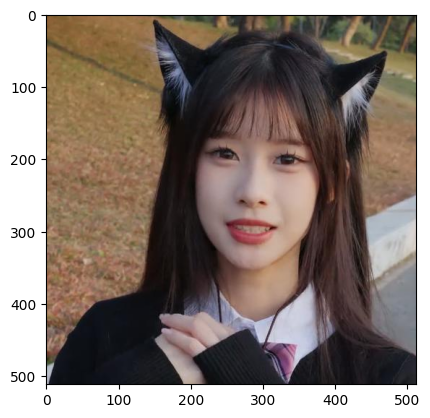

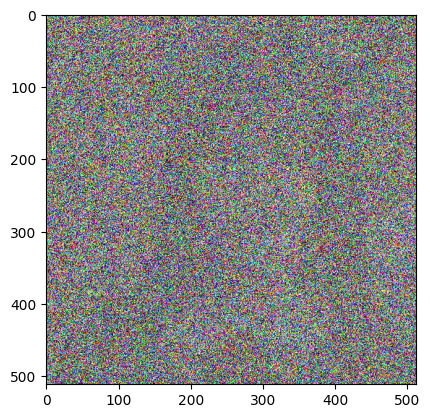

torch.Size([8]) tensor([847, 363, 895,  93, 585, 763, 826, 260], device='cuda:0')


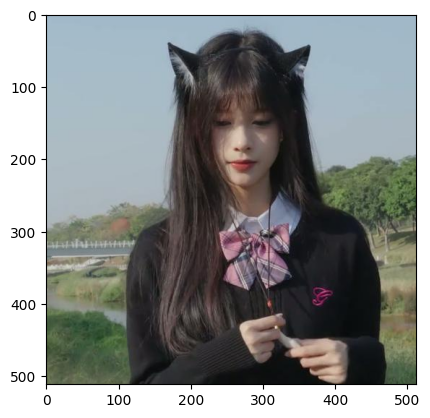

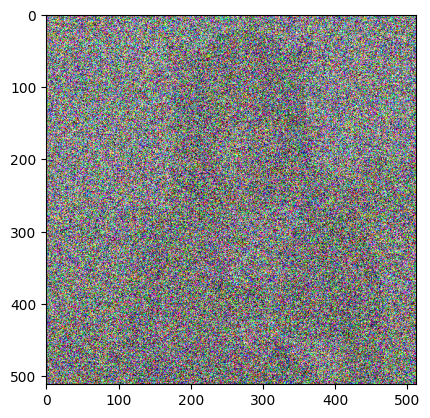

torch.Size([8]) tensor([233, 286,  44, 424, 808, 538, 904, 467], device='cuda:0')


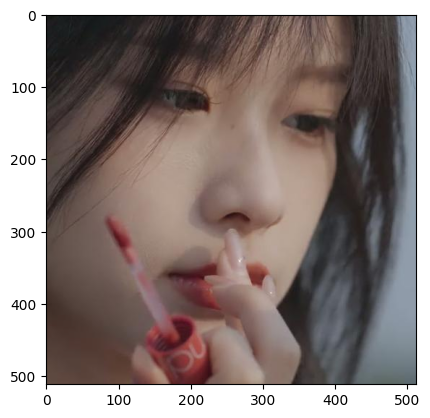

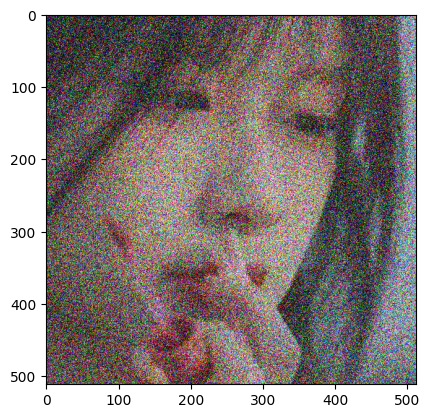

Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


In [16]:
import StableDiffusion.LoraDataSet
import StableDiffusion.DdpmSamplerTorch
import importlib
importlib.reload(StableDiffusion.DdpmSamplerTorch)
importlib.reload(StableDiffusion.LoraDataSet)
from StableDiffusion.Utils import *
from StableDiffusion.DdpmSamplerTorch import DdpmSamplerTorch
from StableDiffusion.LoraDataSet import LoraDataSet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sampler = DdpmSamplerTorch()
sampler.to(device)
loraDataSet = LoraDataSet()
loraDataLoader = DataLoader(loraDataSet,batch_size=8,
                                shuffle=True,num_workers=0,drop_last=True,collate_fn=None)
loraDataSet.__len__()
img,promtTokens,attentionMask = loraDataSet[0]
print(img.shape,promtTokens.shape,attentionMask.shape)

EpochNum = 1
for epoch in tqdm(range(EpochNum),desc='Epoch'):
    for i,data in enumerate(tqdm(loraDataLoader)):
        img,promptTokens,attentionMask = data
        BatchSize,Channel,Height,Width = img.shape
        noise = torch.randn(BatchSize,Channel,Height,Width,dtype=torch.float32,device=device)
        timeSteps =torch.randint(0,1000,(BatchSize,),device=device)
        print(timeSteps.shape,timeSteps)
        imgNoised = sampler.addNoiseBatchTrain(img,noise,timeSteps)
        Utils.showBatchImage(img[:1])
        Utils.showBatchImage(imgNoised[:1])

In [63]:
#print(imgBatch.shape)
print(img.shape)
print(img)
print(promptTokens)
print(attentionMask)

print(img[0].shape)
print(promptTokens[0].shape)
print(attentionMask[0].shape)

torch.Size([2, 3, 512, 512])
tensor([[[[-0.7961, -0.7961, -0.7882,  ...,  0.0980,  0.1294,  0.1686],
          [-0.7804, -0.7804, -0.7804,  ...,  0.0980,  0.1294,  0.1686],
          [-0.7569, -0.7569, -0.7569,  ...,  0.0980,  0.1294,  0.1686],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.2784, -0.2784, -0.2784],
          [-0.2471, -0.2471, -0.2471,  ..., -0.2784, -0.2863, -0.2863],
          [-0.2471, -0.2471, -0.2471,  ..., -0.2863, -0.2863, -0.2941]],

         [[-0.7569, -0.7569, -0.7490,  ...,  0.2000,  0.2314,  0.2706],
          [-0.7412, -0.7412, -0.7412,  ...,  0.2000,  0.2314,  0.2706],
          [-0.7412, -0.7412, -0.7412,  ...,  0.2000,  0.2314,  0.2706],
          ...,
          [-0.4039, -0.4039, -0.4039,  ..., -0.1765, -0.1765, -0.1765],
          [-0.4039, -0.4039, -0.4039,  ..., -0.1765, -0.1843, -0.1843],
          [-0.4039, -0.4039, -0.4039,  ..., -0.1843, -0.1843, -0.1922]],

         [[-0.8039, -0.8039, -0.7961,  ...,  0.3255,  0.3569,  0.3961],
 